

# Binary Classification using Random Forest and Gradient Boosted Trees
**Original Author**: Jacob Nesslage (some components based on scripts developed by [Will Koehrsen's post in Towards Data Science](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0))
**Additional Authors**: Brittany Lopez Barreto, Adam Weingram

**Date Created:** 09/21/2022

**Abstract:** Here we demonstrate the basic workflow for binary classification of vegetated and non-vegetated pixels in satellite imagery using Python. We work with both raster and vector data in Python and provide detailed workflows for implementing two machine learning methods with Scikit-learn---random forests and gradient boosted trees. We use data from Jacob Nesslage's research at the Grayson Riverbend Preserve, a 285 acre riparian restoration site in Grayson, CA.

# Remote sensing tasks you may need to perform before applying machine learning methods

In this section, we will be working with a multispectral raster dataset from a Planet SuperDove overpass over the Grayson Riverbend Preserve on April 7th, 2022. 

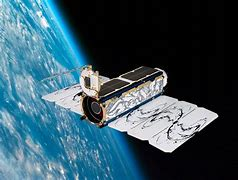

The Planet SuperDove cubesat constellation is a relatively new innovation in remote sensing that provides 8-band, 3 m resolution imagery with daily revisit times. While the radiometric resolution of cubesats leads to fuzzier imagery and a subsequent reduced ability to disciminate small changes in reflectance, Planet has made strides in this regard by harmonizing their data with Sentinel-2 and adding multispectral capabilities with their newest sensor configurations. Below are the spectral characteristics of the multispectral imagery:

Coastal Blue: 431–452 nm

Blue: 465–515 nm

Green I: 513. − 549 nm

Green II: 547. − 583 nm

Yellow: 600–620 nm

Red: 650–680 nm

Red-Edge: 697–713 nm

NIR: 845–885 nm



## Loading and inspecting raster data with rasterio

In this section, we will:

*   Load and inspect the raster data
*   Rescale satellite data from DN to reflectance
*   Calculate common spectral indices for vegetation discrimination
*   Stack and write rasters for subsequent analysis

Python provides many ways of working with raster data products. Based on my experience making this tutorial, not all of them are intuitive (especially for those of us who are used to the raster/terra packages in R). I chose to use rasterio in this section to work with our raster data, but note that there are other options, such as earthpy, gdal, and Pyspatialml. All this to say - this may not be the best way to do things, but it works!

Here, I am opening the raster data using rasterio's .open command in read mode. This allows us to view properties of the raster, such as the dimensions, the crs, the spatial resolution, the extent, and the underlying data structure of the raster.

Let's import our data and familiarize ourselves with the dataset.

The width of this raster is: 1652
The height of this raster is 1372
The number of bands this raster contains is 8
The CRS of this raster is: EPSG:32610
The resolution of this raster is (3.0, 3.0)
The extent of this raster is BoundingBox(left=659217.0, bottom=4157985.0, right=664173.0, top=4162101.0)
The data structure of each raster is ('uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16')



/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


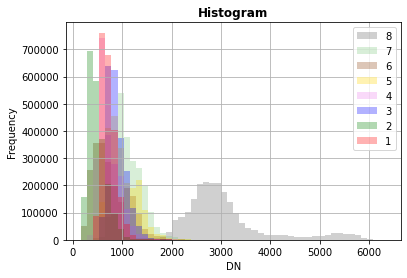

In [ ]:
# Import packages
from osgeo import gdal, gdal_array
import geopandas as gpd
import rasterstats as rs
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rxr
from rasterio import plot
from rasterio.plot import show
import rasterio as rio
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
%matplotlib inline


# Read in our Planet Superdove data over the Grayson Riverbend Preserve
raster = rio.open('/content/Binary_Classification_Tutorial/20220407_182547_92_2477_3B_AnalyticMS_SR_8b_harmonized_clip.tif')

#Familiarize ourselves with the raster dataset 
print(f"The width of this raster is: {raster.width}")
print(f"The height of this raster is: {raster.height}")
print(f"The number of bands this raster contains is: {raster.count}")
print(f"The CRS of this raster is: {raster.crs}")
print(f"The resolution of this raster is: {raster.res}")
print(f"The extent of this raster is: {raster.bounds}")
print(f"The data structure of each raster is: {raster.dtypes}")
print("\n")

# Check histogram 
plot.show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")


Ok, so we now imported our data and know some basic information about the raster dataset. Here's what we know:

*   The raster dimensions are 1652 x 1372 x 8
*   The spatial resolution is 3 m
*   The raster is projected using the UTM Zone 10 N coordinate system (EPSG:32610)
*   The raster occupies some extent defined by the UTM Zone 10 N coordinate system
*   The data is stored as 16-bit unsigned integers

We also have identified a potential problem for future analysis - the data is not scaled to reflectance. This is because, similar to Sentinel-2, Planet rescales their reflectance values by a quantification value of 10,000. Let's go ahead and rectify this, converting to surface reflectance, before generating predictor rasters and extracting pixels from our predictors.





## Rescaling satellite data from DN to reflectance

Using rasterio's .read command, we convert the raster dataset, band by band, into numpy arrays. Note that as soon as you do this, you lose spatial information but gain the ability to work with the data using the same mathematical operations as you would with arrays. Luckily, by keeping the raster variable open, we can retrieve the spatial information that pertains to these arrays later and save our data as a new raster stack.

Our data is now in the following dtype: float64


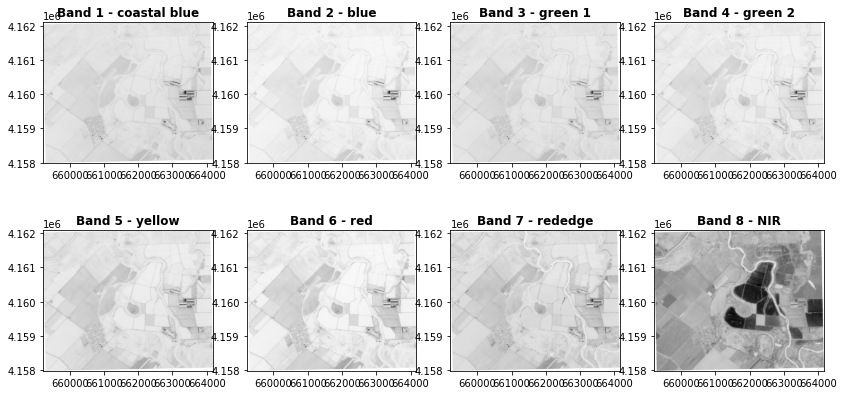

In [ ]:
# Subset bands and rescale to reflectance [0:1]
bands = np.divide(raster.read(), 10000)

band1 = bands[0]
band2 = bands[1]
band3 = bands[2]
band4 = bands[3]
band5 = bands[4]
band6 = bands[5]
band7 = bands[6]
band8 = bands[7]

print(f"Our data is now in the following dtype: {bands.dtype}")

# Plot grayscale images of all available bands - this is a good way to check if 
# the operation was successful, as the rasters will not plot correctly using the 
# show function unless scaled between [0,1]

fig, axis= plt.subplots(2, 4, figsize=(14,7))
show(band1,cmap="Greys",transform=raster.transform,title="Band 1 - coastal blue",ax=axis[0,0])
show(band2,cmap="Greys",transform=raster.transform,title="Band 2 - blue",ax=axis[0,1])
show(band3,cmap="Greys",transform=raster.transform,title="Band 3 - green 1",ax=axis[0,2])
show(band4,cmap="Greys",transform=raster.transform,title="Band 4 - green 2",ax=axis[0,3])
show(band5,cmap="Greys",transform=raster.transform,title="Band 5 - yellow",ax=axis[1,0])
show(band6,cmap="Greys",transform=raster.transform,title="Band 6 - red",ax=axis[1,1])
show(band7,cmap="Greys",transform=raster.transform,title="Band 7 - rededge",ax=axis[1,2])
show(band8,cmap="Greys",transform=raster.transform,title="Band 8 - NIR",ax=axis[1,3])
plt.show()

## Calculating spectral indices

Let's go over the basics of discriminating vegetation from other land classes using remote sensing. First, let's look to the spectral plot below of water, soil, and vegetation.

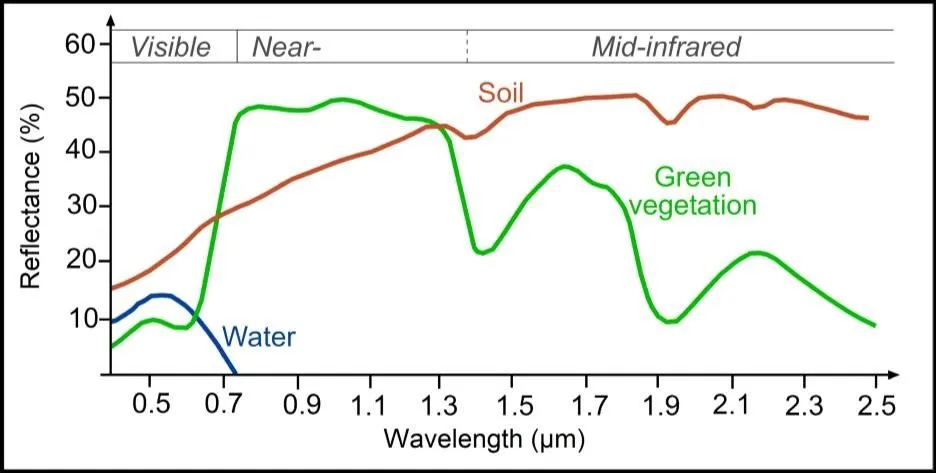

Vegetation is easily discernable from other land classes, due to the chlorophyll absorption of red (~ 0.7 um) and blue light (~ 0.45um), the reflection of green light (~ 0.55 um) due to chlorophyll, as well as high reflection of near infrared light (>0.75um) due to the spongy mesophyll cells in plants. We can use vegetation indices to "exploit" these discriminating signals in remote sensing imagery.

Here, we will use several common vegetation indices to aid our classifers. These all use combinations of the Green, Red, Rededge, and NIR bands of Planet SuperDove's sensor suite. 

Note that ensemble models, such as Random Forest and Gradient Boosted Trees, are fairly robust to highly correlated variables. Remember that with different machine learners, correlated variables derived from similar bands in imagery may present a problem.

Below are the vegetation indices chosen for this classification task:

* $\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}$
* $\text{GNDVI} = \text{NIR} - \frac{Green}{\text{NIR} + \text{Green}}$
* $\text{NDRE} = \frac{\text{NIR} - \text{Red Edge}}{\text{NIR} + \text{Red Edge}}$
* $\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}$
* $\text{DVI} = \text{NIR} - \text{Red}$
* $\text{SR} = \frac{NIR}{Red}$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


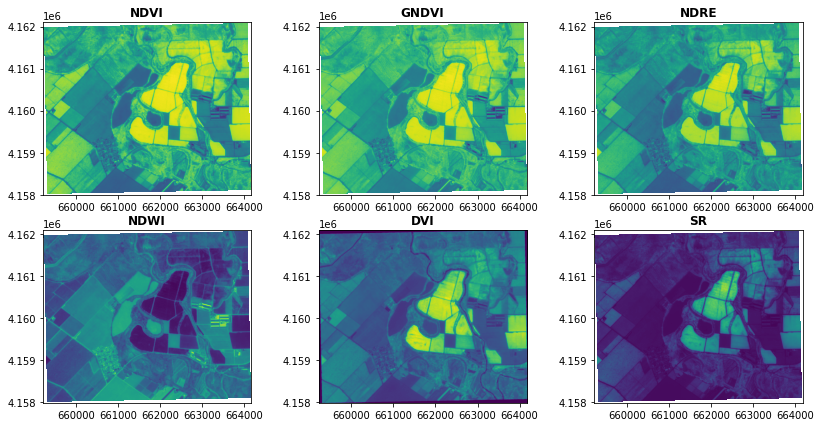

In [ ]:
# Calculate predictor variables

NDVI = (band8 - band6) / (band8 + band6)   # Normalized Difference Vegetation Index (NDVI)
GNDVI = (band8 - band4) / (band8 + band4)  # Green Normalized Difference Vegetation Index (GNVDI)
NDRE = (band8 - band7) / (band8 + band7)   # Normalized Difference Red Edge Index (NDRE)
NDWI = (band4 - band8) / (band4 +band8)    # Normalized Difference Water Index (NDWI)
DVI = band8 - band6                        # DVI
SR = band8/band6                           # SR

# Plot predictors - note the transform variable, which adds in geospatial information
fig, axis= plt.subplots(2, 3, figsize=(14,7))
show(NDVI, title="NDVI", transform=raster.transform, ax=axis[0,0])
show(GNDVI, title="GNDVI", transform=raster.transform, ax=axis[0,1])
show(NDRE, title="NDRE", transform=raster.transform, ax=axis[0,2])
show(NDWI, title="NDWI", transform=raster.transform, ax=axis[1,0])
show(DVI, title = "DVI", transform=raster.transform, ax=axis[1,1])
show(SR, title="SR", transform=raster.transform, ax=axis[1,2])
plt.show()

## Writing rasters with rasterio

Ok, so we have a bunch of predictors - 14 to be precise (8 bands + 6 VI's) - that we can use to classify vegetation. 

Let's write a raster out with all of these predictors. Note that we are still working with the data as separate arrays, which lack geospatial data on crs and transformations. Rasterio lets us add the geospatial data back into the mix and save a new dataset of stacked predictors. 

In [ ]:
#Write a stack of rasters for use in zonal statistics
with rio.open('/content/Binary_Classification_Tutorial/predictors.tiff', 'w', driver='Gtiff',
                          width=raster.width, height=raster.height,
                          count=14,
                          crs=raster.crs,
                          transform=raster.transform,
                          dtype='float64'                   
                         ) as predictors:
  predictors.write(band1, 1)  #Coastal Blue
  predictors.write(band2, 2)  #Blue
  predictors.write(band3, 3)  #Green 1
  predictors.write(band4, 4)  #Green 2
  predictors.write(band5, 5)  #Yellow
  predictors.write(band6, 6)  #Red
  predictors.write(band7, 7)  #Rededge
  predictors.write(band8, 8)  #NIR
  predictors.write(NDVI, 9)   #NDVI
  predictors.write(GNDVI, 10) #GNDVI
  predictors.write(NDRE, 11)  #NDRE
  predictors.write(NDWI, 12)  #NDWI
  predictors.write(DVI, 13)   #DVI
  predictors.write(SR, 14)    #SR
  predictors.close()

#Open the raster we just saved and check to make sure it's formatted correctly
predictors = rio.open('/content/Binary_Classification_Tutorial/predictors.tiff') 
#show((predictors,9),title="NDVI")
#Familiarize ourselves with the raster dataset 
print(f"The width of this raster is: {predictors.width}")
print(f"The height of this raster is: {predictors.height}")
print(f"The number of bands this raster contains is: {predictors.count}")
print(f"The CRS of this raster is: {predictors.crs}")
print(f"The resolution of this raster is: {predictors.res}")
print(f"The extent of this raster is: {predictors.bounds}")
print(f"The data structure of each raster is: {predictors.dtypes}")

The width of this raster is: 1652
The height of this raster is 1372
The number of bands this raster contains is 14
The CRS of this raster is: EPSG:32610
The resolution of this raster is (3.0, 3.0)
The extent of this raster is BoundingBox(left=659217.0, bottom=4157985.0, right=664173.0, top=4162101.0)
The data structure of each raster is ('float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64')



## View shapefile containing vegetation validation data

We have been working exclusively with the raster data so far. However, the general workflow of applying machine learning models for classification of remote sensing data usually involves extracting pixels that correspond to your classes of interest. Typically, these pixels of interested are identified by geospatial information contained in vector datasets, such as shapefiles, which have geolocated points, lines, or polygons delineating these classes.

Here, I have a shapefile of 119 geolocated points, obtained using a Trimble Geo7X handheld GPS unit in the field between April 6th and April 15th. This data is accurate to 5-10 cm with post-processing correction, which is more than enough for our application.

Let's visualize this data:

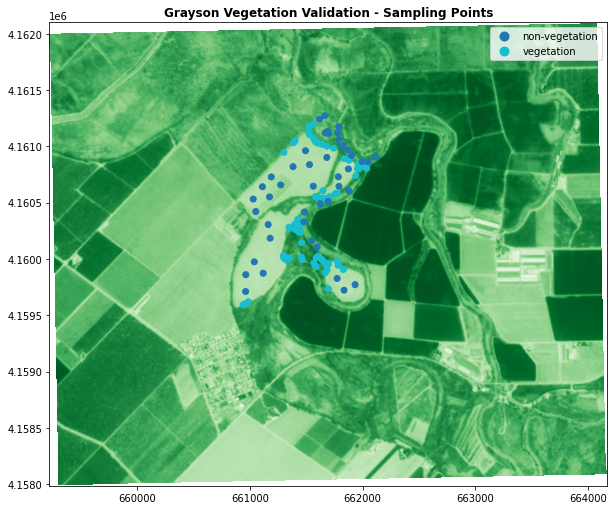

In [ ]:
# Read in shapefile containing validation data on vegetated and non-vegetated points in the Grayson Riverbend Preserve
shapefile = gpd.read_file("/content/Binary_Classification_Tutorial/binary_classifier.shp")

# Visualize where these sample points lie on the map
fig, ax = plt.subplots(figsize=(10, 10))
shapefile.plot(ax=ax,column="CLASS", legend=True, facecolor="Greys")
show((NDVI), ax=ax, transform=predictors.transform, title="Grayson Vegetation Validation - Sampling Points (Over NDVI)", cmap="Greens")
plt.show()

-------------------------------------------------------------------------------------------------

The next step is to extract the pixel values from the raster that fall within the points specified on the map.

##Challenge: Pixel Extraction in Python

I could not figure out how to extract pixel values from the rasters in Python using the points in the shapefile. Given that the goal of this tutorial is to demonstrate binary classification of imagery, I decided to use R to create the table of predictor values with their respective classes and move on. 

However, I think it would be worthwhile to learn how to do this in Python (and not figuring this out is really bugging me!). I was trying to apply zonal statistics to obtain the values using the script below without much success. Please let me know if you have ideas on how to accomplish this task! 

For those who are curious, in R, I accomplished this using the following:

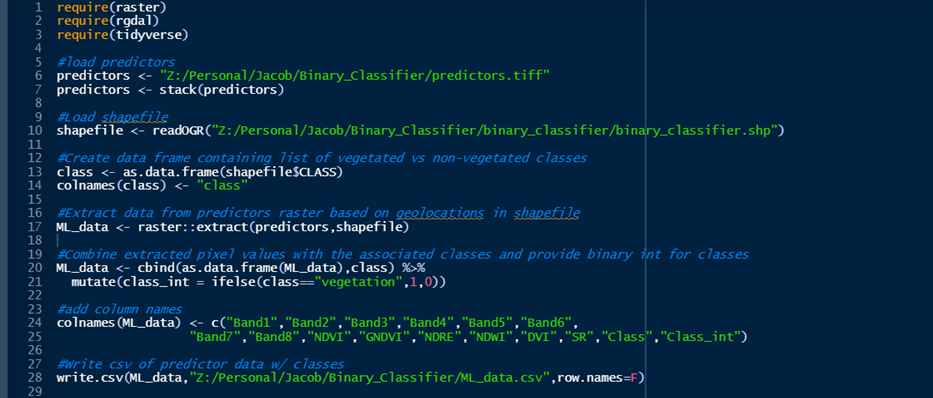

I've provided a starting place below. Zonal stats should be the method to use for this process.

In [ ]:
#pred_table = rs.zonal_stats(shapefile,predictors,stats="mean",band=1,affine=predictors.affine)


---------------------------------------------------------------------------------------

#Training and test data

Ok, so now we have to bring in our .csv file containing our training and test data. We can easily read .csv files into Python using pandas.

In [ ]:
# Read in data and display first 5 rows
import pandas as pd

features = pd.read_csv('/content/Binary_Classification_Tutorial/ML_data.csv')
features.head(5)

,Band1,Band2,Band3,Band4,Band5,Band6,Band7,Band8,NDVI,GNDVI,NDRE,NDWI,DVI,SR,Class,Class_int
0,0.0718,0.0570,0.0935,0.0767,0.1080,0.0883,0.1204,0.2930,0.536848,0.585069,0.417513,-0.585069,0.2047,3.318233,vegetation,1
1,0.0754,0.0639,0.0912,0.0767,0.1098,0.0891,0.1205,0.2987,0.540485,0.591369,0.425095,-0.591369,0.2096,3.352413,vegetation,1
2,0.0750,0.0636,0.0970,0.0832,0.1153,0.0935,0.1188,0.2986,0.523081,0.564170,0.430762,-0.564170,0.2051,3.193583,vegetation,1
3,0.0653,0.0437,0.0808,0.0557,0.0806,0.0581,0.0939,0.2600,0.634706,0.647133,0.469342,-0.647133,0.2019,4.475043,vegetation,1
4,0.0645,0.0449,0.0815,0.0614,0.0846,0.0631,0.0975,0.2598,0.609167,0.617684,0.454240,-0.617684,0.1967,4.117274,vegetation,1


Notice the format of the data, with each predictor set up as a column, along with relevant classification data. Also note that each row cooresponds to your validated classification data for a specied point from the shapefile we viewed earlier. This is a very common way to set up your training/test data for most machine learning tasks in remote sensing.

## Summary Statistics of Predictor Variables

It is also helpful to view summary statistics of your data to ensure that calculated values look correct before proceeding.

In [ ]:
print('The shape of our features is:', features.shape)


# Descriptive statistics for each column
features.describe()



The shape of our features is: (119, 16)


,Band1,Band2,Band3,Band4,Band5,Band6,Band7,Band8,NDVI,GNDVI,NDRE,NDWI,DVI,SR,Class_int
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,0.073410,0.053368,0.092104,0.076123,0.106371,0.085555,0.115688,0.254532,0.502377,0.539172,0.378952,-0.539172,0.168977,3.326785,0.630252
std,0.013087,0.016669,0.018481,0.021376,0.026250,0.031241,0.029553,0.046593,0.129875,0.094000,0.089321,0.094000,0.049045,1.262118,0.484778
min,0.047900,0.025400,0.060500,0.041100,0.065700,0.036300,0.043700,0.113900,0.256656,0.337262,0.206297,-0.739155,0.070900,1.690544,0.000000
25%,0.063750,0.040500,0.077550,0.059600,0.084050,0.060400,0.097900,0.236900,0.408361,0.469269,0.310976,-0.606981,0.126050,2.380442,0.000000
50%,0.070600,0.050500,0.089500,0.074400,0.104300,0.080500,0.116400,0.264600,0.522680,0.550372,0.392801,-0.550372,0.172900,3.190062,1.000000
75%,0.082500,0.063750,0.105200,0.091000,0.121350,0.106200,0.135000,0.283900,0.593413,0.606981,0.443159,-0.469269,0.204650,3.919692,1.000000
max,0.115800,0.103700,0.151600,0.146200,0.184400,0.174500,0.194100,0.326800,0.788338,0.739155,0.571209,-0.337262,0.274300,8.449036,1.000000


##Data Wrangling to split features from labels for classification

Before you can split your training and test data, you need to split your classification labels from your predictor features. 

Below, I set the labels to be the binary numeric version of the classification (i.e. 1 for vegetation, 0 for non-vegetatation), which is required for the machine learning models. 

I also create a key for later viewing, just in case we forget what 0 and 1 correspond to when we view our outputs 6 months later. 

We want our features to also be separate from the classification labels, so we separate them here,too.

In [ ]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = features[["Class_int"]]
labels = np.array(labels)
print(labels)

#Vegetation vs non-vegetation key
key = features[["Class","Class_int"]]

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(["Class","Class_int"], axis = 1)
print(features)
# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)


[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
      Band1   Band2   Band3   Band4   Band5   Band6   Band7   Band8      NDVI  \
0    0.0718  0.0570  0.0935  0.0767  0.1080  0.0883  0.1204  0.2930  0.536848   
1    0.0754  0.0639  0.0912  0.0767  0.1098  0.0891  0.1205  0.2987  0.540485   
2    0.0750  0.0636  0.0970  0.0832  0.1153  0.0935  0.1188  0.2986  0.523081   
3    0.0653  0.0437  0.0808  0.0557  0.0806  0.0581  0.0939  0.2600  0.634706   

## Splitting Training and Testing Data

We can use scikit-learn's train_test_split function to split our data into training and test data. We will do a 60% training / 40% testing split, which is a very common way to divide your data for samller datasets.

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets (60% train / 40% test)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.4, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (71, 14)
Training Labels Shape: (71, 1)
Testing Features Shape: (48, 14)
Testing Labels Shape: (48, 1)


#Random Forest Classification w/ Scikit-learn

We are finally ready to start applying machine learning to our data! We will start by learning how to train, test, and apply Random Forest models to our remote sensing data.

I added a highly descriptive explanation of Random Forest algorithms from IBM: https://www.ibm.com/cloud/learn/random-forest#:~:text=Random%20forest%20is%20a%20commonly-used%20machine%20learning%20algorithm,as%20it%20handles%20both%20classification%20and%20regression%20problems. 

In summary:

"Random forest is a commonly-used machine learning algorithm trademarked by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems.

The random forest algorithm is made up of a collection of decision trees, and each tree in the ensemble is comprised of a data sample drawn from a training set with replacement, called the bootstrap sample. Of that training sample, one-third of it is set aside as test data, known as the out-of-bag (oob) sample, which we’ll come back to later. Another instance of randomness is then injected through feature bagging, adding more diversity to the dataset and reducing the correlation among decision trees. Depending on the type of problem, the determination of the prediction will vary. For a regression task, the individual decision trees will be averaged, and for a classification task, a majority vote—i.e. the most frequent categorical variable—will yield the predicted class. Finally, the oob sample is then used for cross-validation, finalizing that prediction.

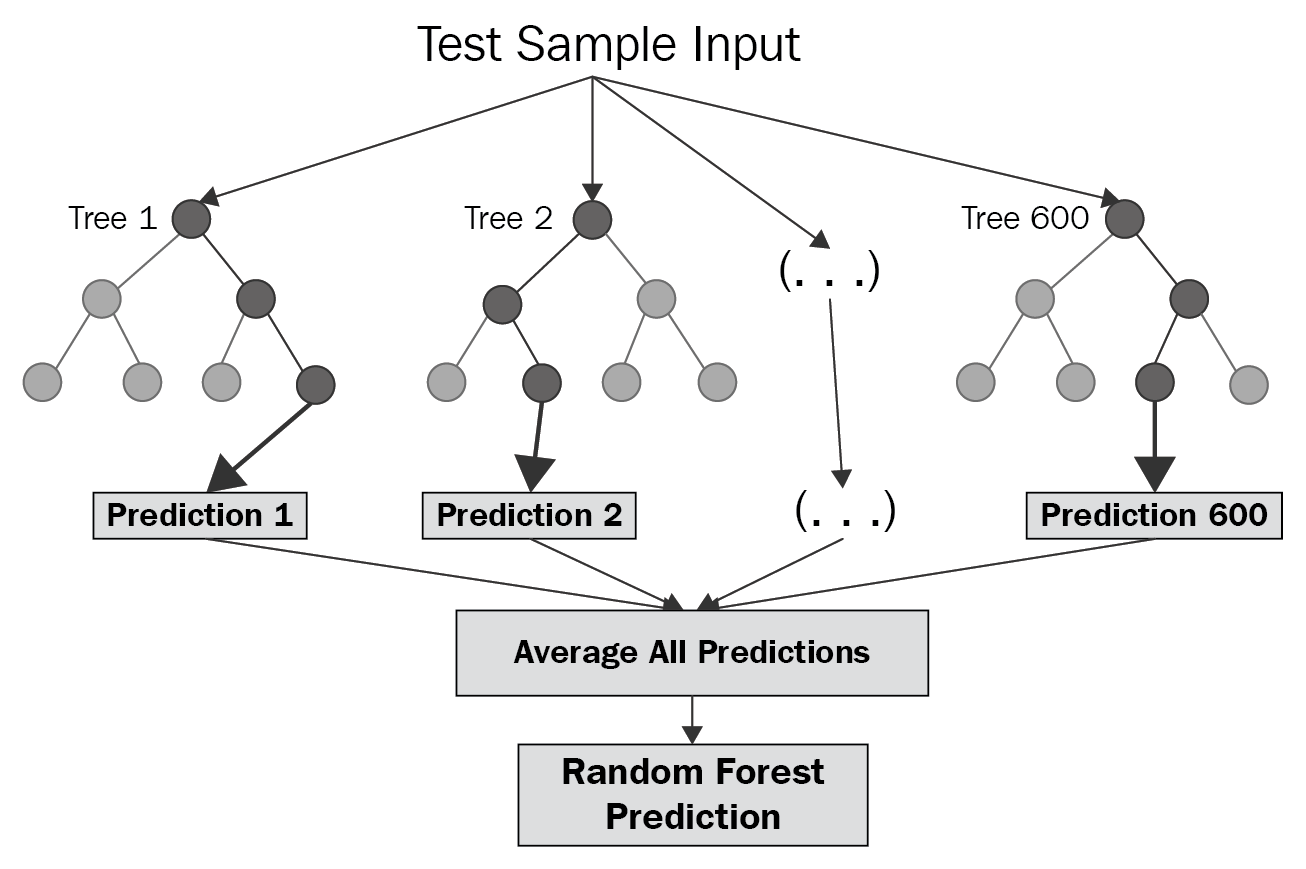

Random forest algorithms have three main hyperparameters, which need to be set before training. These include node size, the number of trees, and the number of features sampled. From there, the random forest classifier can be used to solve for regression or classification problems." 

##Tuning Hyperparameters

The first step in training a Random Forest model is to tune your hyperparameters. 

Random forest algorithms have three main hyperparameters, which need to be set before training. These include node size, the number of trees, and the number of features sampled. From there, the random forest classifier can be used to solve for regression or classification problems.

Here, we will tune for two hyperparameters - number of trees and the method used to determine maximum features or predictors used in a tree.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
n_list = [100,200,300,400,500,750,1000]

#Tune number of trees
for n_estimators in n_list:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators,max_features="sqrt",bootstrap=True, random_state=42)
    rf_clf.fit(train_features, train_labels)

    print("Number of trees: ", n_estimators)
    print("Maximum features: sqrt")
    print("Accuracy score (training): {0:.3f}".format(rf_clf.score(train_features, train_labels)))
    print("Accuracy score (validation): {0:.3f}".format(rf_clf.score(test_features, test_labels)))

    rf_clf = RandomForestClassifier(n_estimators=n_estimators,max_features="auto",bootstrap=True, random_state=42)
    rf_clf.fit(train_features, train_labels)

    print("Number of trees: ", n_estimators)
    print("Maximum features: auto")
    print("Accuracy score (training): {0:.3f}".format(rf_clf.score(train_features, train_labels)))
    print("Accuracy score (validation): {0:.3f}".format(rf_clf.score(test_features, test_labels)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Number of trees:  100
Maximum features: sqrt
Accuracy score (training): 1.000
Accuracy score (validation): 0.938
Number of trees:  100
Maximum features: auto
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of trees:  200
Maximum features: sqrt
Accuracy score (training): 1.000
Accuracy score (validation): 0.958


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Number of trees:  200
Maximum features: auto
Accuracy score (training): 1.000
Accuracy score (validation): 0.958


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of trees:  300
Maximum features: sqrt
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Number of trees:  300
Maximum features: auto
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of trees:  400
Maximum features: sqrt
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Number of trees:  400
Maximum features: auto
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of trees:  500
Maximum features: sqrt
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Number of trees:  500
Maximum features: auto
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of trees:  750
Maximum features: sqrt
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Number of trees:  750
Maximum features: auto
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of trees:  1000
Maximum features: sqrt
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Number of trees:  1000
Maximum features: auto
Accuracy score (training): 1.000
Accuracy score (validation): 0.938


Here, we find that the best number of trees is 200 and that it doesn't really matter if the maximum number of features is automatically determined or if it is determined by sqrt(N) predictors. Now we can train our best model possible.

## Model Fitting and Prediction

Now, let's train our best model!

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Define model parameters
rf = RandomForestClassifier(n_estimators = 200, max_features="sqrt",bootstrap=True,random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

pred = rf.predict(test_features)
 
from sklearn import metrics 
print()

print("Accuracy of the model: ", metrics.accuracy_score(test_labels, pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  



Accuracy of the model:  0.9583333333333334


## Feature Importance

Something nice about ensemble based models is that you get feature importance from the model. This tells you which features or predictors are the most important for classification in your models.

In [ ]:
import pandas as pd
feature_imp = pd.Series(rf.feature_importances_, index = feature_list).sort_values(ascending = False)
feature_imp

DVI      0.240011
Band8    0.173870
SR       0.087680
GNDVI    0.087667
NDVI     0.078851
NDWI     0.070045
NDRE     0.046899
Band3    0.042721
Band7    0.039724
Band1    0.034238
Band6    0.034166
Band4    0.029330
Band2    0.018879
Band5    0.015919
dtype: float64

Here, we see the difference vegetation index and the NIR band are very important for identifying vegetation in juxtaposition to non-vegetated classes.

## ROC Curves

A ROC curve is a plot of the true positive rate (Sensitivity) in function of the false positive rate (100-Specificity) for different cut-off points of a parameter. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

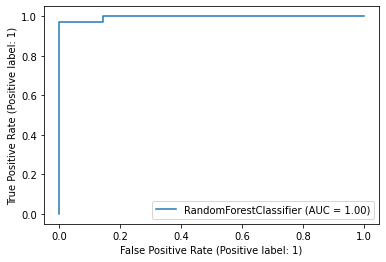

In [ ]:
from sklearn.metrics import RocCurveDisplay
roc = RocCurveDisplay.from_estimator(rf, test_features, test_labels)
plt.show()

##Create classified raster using trained Random Forest model

Now the best part - applying our model to the entire raster dataset!

In [ ]:
#Apply trained Random Forest model to raster dataset
from pyspatialml import Raster
stack = Raster(predictors)
result = stack.predict(estimator=rf,dtype="float64",nodata=-999)



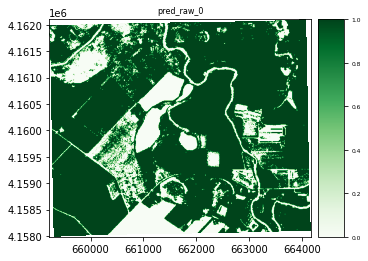

In [ ]:
# plot classification result

result.iloc[0].cmap = "Greens"
result.iloc[0].categorical = True
result.plot()
plt.show()

#Gradient Boosted Classification w/ Scikit-learn

Gradient boosted trees are an ensemble learning model that specifically uses decision trees and boosting to improve the model's results on a dataset. They typically have decision trees with performances that are not too strong—slightly better than chance.

A single decision tree whose results are "too good" may be overfitting the data. As a result, the ensemble model will exhibit worse performance. To avoid this in practice, machine learning experts simplify each decision tree: limiting its depth to prevent it from fitting too many features.

With gradient boosting, the dataset is treated explicitly as a numerical optimization problem to be solved with gradient descent.

To begin with, the first tree is trained to fit the dataset. Then, a loss function is generated from this weak model to understand the errors that it has made. The learner uses gradient descent to try to reduce errors by finding the local minimum of this loss function. Essentially, the learner moves “downward” in the direction where the loss decreases the fastest, correcting for the previous model's mistakes.

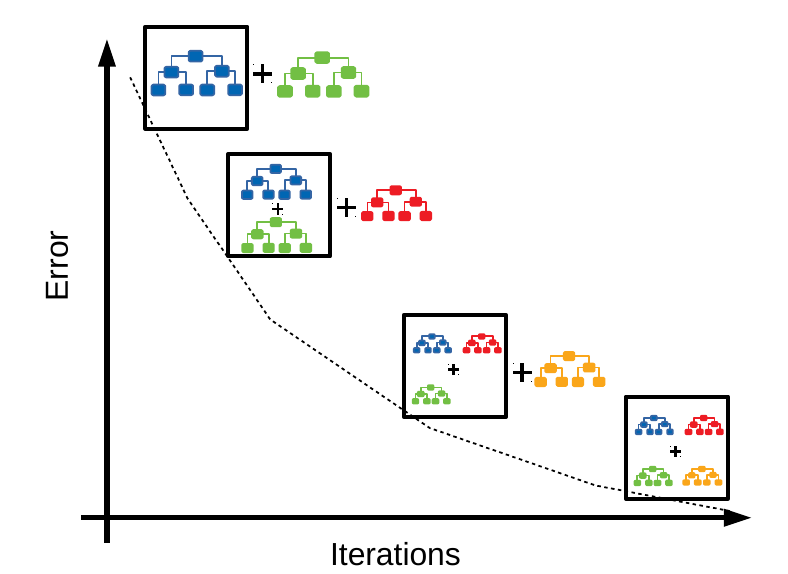

Essentially, this machine learning method employs a Bayesian approach to modeling, which is extremely effective. Many machine learning competitions have been won using variations of gradient boosting ensemble methods, such as XGBoost.

Let's give this machine learning technique a try!

## Tuning Hyperparameters

Gradient Boosting methods require much more training with hyperparameters to get the best model. Here, I will only focus on two parameters - learning rate and number of trees. 

The learning rate essentially provides weights to sequential trees as their outputs are summed, slowing down the rate at which the model converges on a solutions. This usually improves model performance.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

#Tune learning rate
for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=42)
    gb_clf.fit(train_features, train_labels)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_features, train_labels)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(test_features, test_labels)))



#Tune number of trees
n_list = [5,10,15,20,25,50,100,200,300,400,500,750,1000]

for n_estimators in n_list:
    gb_clf = GradientBoostingClassifier(n_estimators=n_estimators,learning_rate=learning_rate, max_features=2, max_depth=2, random_state=42)
    gb_clf.fit(train_features, train_labels)

    print("Number of trees: ", n_estimators)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_features, train_labels)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(test_features, test_labels)))




/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

Learning rate:  0.05
Accuracy score (training): 0.986
Accuracy score (validation): 0.938
Learning rate:  0.075
Accuracy score (training): 0.986
Accuracy score (validation): 0.917
Learning rate:  0.1
Accuracy score (training): 0.986
Accuracy score (validation): 0.896
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.938
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.958
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.938
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.938
Number of trees:  5
Accuracy score (training): 0.986
Accuracy score (validation): 0.917
Number of trees:  10
Accuracy score (training): 1.000
Accuracy score (validation): 0.938
Number of trees:  15
Accuracy score (training): 1.000
Accuracy score (validation): 0.938
Number of trees:  20
Accuracy score (training): 1.000
Accuracy score (validation): 0.938
Number of trees:  25
Accur

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of trees:  100
Accuracy score (training): 1.000
Accuracy score (validation): 0.958
Number of trees:  200
Accuracy score (training): 1.000
Accuracy score (validation): 0.958
Number of trees:  300
Accuracy score (training): 1.000
Accuracy score (validation): 0.958


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of trees:  400
Accuracy score (training): 1.000
Accuracy score (validation): 0.958
Number of trees:  500
Accuracy score (training): 1.000
Accuracy score (validation): 0.958


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of trees:  750
Accuracy score (training): 1.000
Accuracy score (validation): 0.958


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of trees:  1000
Accuracy score (training): 1.000
Accuracy score (validation): 0.958


For this model, a learning rate = 0.5 and trees = 50 appears to be the best solution

##Model Fitting and Prediction

In [ ]:
# Import the model we are using
from sklearn.ensemble import GradientBoostingClassifier

#Define parameters for model
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.5, max_features=2, max_depth=2, random_state=42)
# Train the model on training data
gb.fit(train_features, train_labels);

pred = gb.predict(test_features)
 
from sklearn import metrics 
print()

print("Accuracy of the model: ", metrics.accuracy_score(test_labels, pred))


Accuracy of the model:  0.9583333333333334


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Feature Importance

In [ ]:
import pandas as pd
feature_imp = pd.Series(gb.feature_importances_, index = feature_list).sort_values(ascending = False)
feature_imp

DVI      0.343391
SR       0.292905
Band8    0.203042
Band7    0.045586
NDRE     0.038544
NDVI     0.020544
NDWI     0.017279
Band1    0.016640
Band6    0.016382
Band5    0.002312
Band4    0.001661
Band3    0.001168
GNDVI    0.000471
Band2    0.000076
dtype: float64

Similar to our Random Forest model, DVI is our top predictor.

##ROC Curves

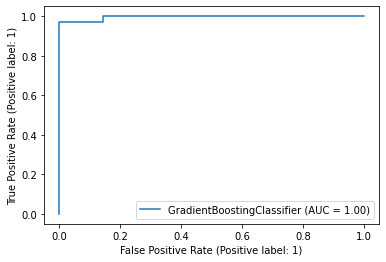

In [ ]:
from sklearn.metrics import RocCurveDisplay
roc = RocCurveDisplay.from_estimator(gb, test_features, test_labels)
plt.show()

## Create classifed raster using trained Gradient Boosting Classifer model

In [ ]:
#Apply trained Gradient Boosting Classifer model to raster dataset
from pyspatialml import Raster
stack = Raster(predictors)
result_gb = stack.predict(estimator=gb,dtype="float64",nodata=-999)



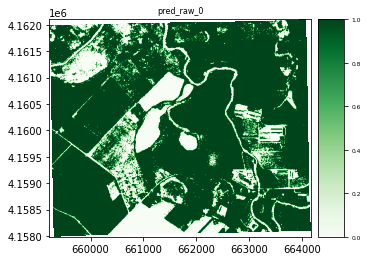

In [ ]:
# plot classification result
result_gb.iloc[0].cmap = "Greens"
result_gb.iloc[0].categorical = True
result_gb.plot()
plt.show()

#Conclusion 

In this tutorial, we have covered the basic tasks required to create binary vegetation classification models using machine learning in Python. Of course, these methods extend to multi-classification tasks with minor edits. Feel free to try these methods with your own data - machine learning is a powerful tool when combined with remote sensing!

